In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Flatten, Dropout
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
column_names = ['user_id','activity','timestamp','x_axis','y_axis','z_axis']

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MCA Main Project/WISDM_ar_v1.1_raw.txt', header=None, names = column_names)

In [5]:
df.head(11)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [6]:
# removing null values

df = df.dropna()
df.shape

(1098203, 6)

In [7]:
# # processing z-axis values - removing ; from the value

# df['z_axis'] = df['z_axis'].str.replace(';','')
# df['z_axis'] = df['z_axis'].apply(lambda x:float(x))

In [8]:
# drop rows where timestamp is 0

df = df[df['timestamp'] !=0]

In [9]:
# arrange data in ascending order of user and timestamp

df = df.sort_values(by=['user_id','timestamp'],ignore_index=True)

In [10]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


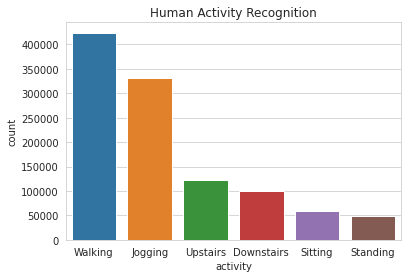

In [11]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Human Activity Recognition')
plt.show()

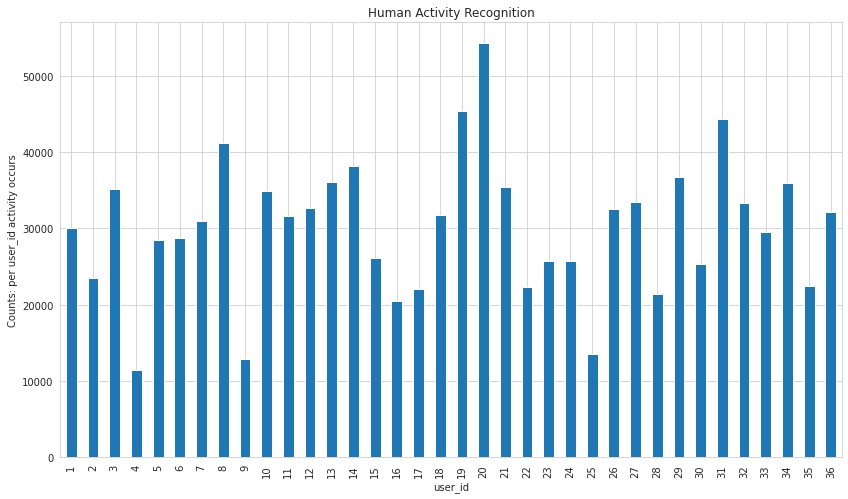

In [12]:
ax = df.groupby(['user_id'])['user_id'].count().plot.bar(title="Human Activity Recognition", ylabel='Counts: per user_id activity occurs',figsize=(14,8))

In [13]:
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 50
batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015

In [14]:
segments = []
labels = []

for i in range(0, df.shape[0] - n_time_steps, step):
    
    xs = df['x_axis'].values[i: i + 50]
    ys = df['y_axis'].values[i: i + 50]
    zs = df['z_axis'].values[i: i + 50]
    
    label = stats.mode(df['activity'][i: i + 50])[0][0]
    
    segments.append([xs,ys,zs])
    
    labels.append(label)

# reshape the segments which is(list of arrays) to a list

reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [15]:
reshaped_segments.shape

(108531, 50, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=random_seed)

In [17]:
# Building Model Architecture

model = Sequential()

# RNN layer

#model.add(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2] )))

model.add(GRU(units=128, input_shape=(X_train.shape[1],X_train.shape[2] )))

# Dropout layer

model.add(Dropout(0.5))

# Dense layer with ReLu

model.add(Dense(units=64, activation='relu'))

# Softmax layer

model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 59,718
Trainable params: 59,718
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2, batch_size=batch_size, verbose=1)

Epoch 1/50
68/68 [==============================] - 47s 657ms/step - loss: 1.1176 - accuracy: 0.5539 - val_loss: 0.6086 - val_accuracy: 0.7865
Epoch 2/50
68/68 [==============================] - 47s 697ms/step - loss: 0.5469 - accuracy: 0.8068 - val_loss: 0.4957 - val_accuracy: 0.8173
Epoch 3/50
68/68 [==============================] - 46s 681ms/step - loss: 0.4795 - accuracy: 0.8265 - val_loss: 0.4555 - val_accuracy: 0.8309
Epoch 4/50
68/68 [==============================] - 45s 658ms/step - loss: 0.4350 - accuracy: 0.8419 - val_loss: 0.4077 - val_accuracy: 0.8469
Epoch 5/50
68/68 [==============================] - 45s 664ms/step - loss: 0.3962 - accuracy: 0.8555 - val_loss: 0.3754 - val_accuracy: 0.8595
Epoch 6/50
68/68 [==============================] - 45s 663ms/step - loss: 0.3654 - accuracy: 0.8695 - val_loss: 0.3430 - val_accuracy: 0.8747
Epoch 7/50
68/68 [==============================] - 45s 665ms/step - loss: 0.3329 - accuracy: 0.8823 - val_loss: 0.3059 - val_accuracy: 0.8900

In [20]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 4s 201ms/step - loss: 0.1192 - accuracy: 0.9689
Test Accuracy : 0.9688579440116882
Test Loss : 0.11915632337331772


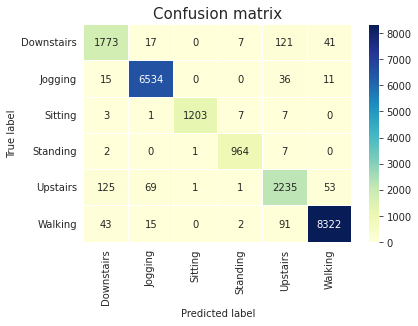

In [21]:
# Confusion matrix
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True,linewidths=0.1,fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

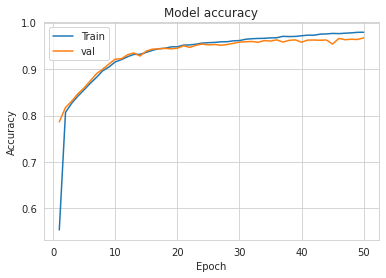

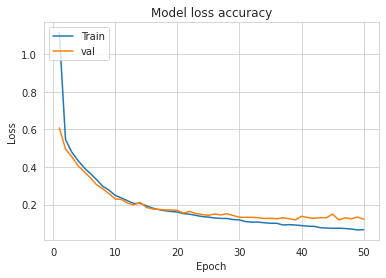

In [22]:
def plot_learningCurve(history,epochs):

  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss accuracy')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

plot_learningCurve(history,50)